# **Evaluating a RAG Application using Qdrant and RAGAS**

**Introduction**

Creating a foundation for a Retrieval-Augmented Generation (RAG) pipeline is often straightforward. However, optimizing and tweaking it for production and ensuring top-notch response quality presents formidable hurdles. Given the multitude of tools and parameters available, identifying the ideal configuration can feel overwhelming.

In this notebook, we delve into the evaluation, visualization, and analysis of RAG systems using a blend of open-source libraries. Our toolkit includes embedding model from [MixedBread.ai](https://www.mixedbread.ai/docs/embeddings/mxbai-embed-large-v1#model-description) ,  [RAGAS-Haystack](https://docs.haystack.deepset.ai/docs/ragasevaluator) for evaluation and [Qdrant](https://qdrant.tech/) for context augmentation, serving as a vector database to construct the RAG pipeline.

Throughout this article, we'll leverage data sourced from [Qdrant](https://qdrant.tech/)'s documentation and articles to create an assistant capable of answering queries about Qdrant. Additionally, we'll explore methods for generating synthetic test data, including those provided by RAGAS.

❗This notebook requires **OpenAI Key**

In [1]:
#pip install qdrant_client datasets langchain pandas fastembed==0.2.6 qdrant-client[fastembed] ragas-haystack matplotlib openai

In [2]:
#!pip install ipywidgets

### **1. Import relevant packages**

In [1]:
import os
import json
import openai
import pandas as pd
import qdrant_client
from getpass import getpass
from tqdm.notebook import tqdm
from datasets import load_dataset
from typing import Optional, List, Tuple
from qdrant_client import QdrantClient, models
from qdrant_client.http.models import PointStruct
from langchain_core.language_models import BaseChatModel

In [2]:
from dotenv import load_dotenv
from haystack import Pipeline
from haystack_integrations.components.evaluators.ragas import RagasEvaluator, RagasMetric

In [3]:
## Load environment variables
load_dotenv()

True

### **2. Setup your openai key**

In [4]:
if not (openai_api_key := os.environ.get("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

### **3.  Retrieve the documents / dataset to be used**

In [8]:
# HF Dataset with data from Qdrant's documentation
dataset = load_dataset("atitaarora/qdrant_doc", split="train")


In [9]:
#Total num docs in dataset
dataset.info.splits.total_num_examples

240

### **4. Process dataset as Haystack document for further processing**

In [10]:
from haystack.dataclasses import Document as HaystackDocument

## Dataset to haystack document
haystack_docs = [
    HaystackDocument(content=doc["text"], meta={"source": doc["source"]})
    for doc in tqdm(dataset)
]

len(haystack_docs)

  0%|          | 0/240 [00:00<?, ?it/s]

240

### **5. (Optional) Baseline Test Evaluation Dataset Generation using Ragas**

We can use the testdataset generator from RAGAS or use synthetic evaluation dataset generation through T5 or OpenAI as part of other notebooks.

In [ ]:
from langchain.document_loaders import DirectoryLoader
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context

generator = TestsetGenerator.with_openai()
testset = generator.generate_with_langchain_docs(langchain_docs[:10], test_size=10,
                                                 raise_exceptions=False, with_debugging_logs=False,
                                                 distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25})

### **5a. Evaluation dataset to Pandas for better visualization**

In [ ]:
df = testset.to_pandas()
df.head(10)

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,What is the process of downloading and running...,[---\n\ntitle: Quickstart\n\nweight: 11\n\nali...,"First, download the latest Qdrant image from D...",simple,[{'source': 'documentation/quick-start.md'}],True
1,What is the purpose of the Qdrant vector searc...,[---\n\ndraft: false\n\ntitle: Startup Search\...,This demo uses short descriptions of startups ...,simple,[{'source': 'demo/demo-1.md'}],True
2,How do you load data into a Qdrant collection?,[---\n\ntitle: Quickstart\n\nweight: 11\n\nali...,nan,simple,[{'source': 'documentation/quick-start.md'}],True
3,What is the purpose of the Startup Search demo?,[---\n\ndraft: false\n\ntitle: Startup Search\...,This demo uses short descriptions of startups ...,simple,[{'source': 'demo/demo-1.md'}],True
4,What are the next steps after conducting a vec...,"[ string_value: ""London""\n\n }\n\n}\n\nscore:...","Now that you know how Qdrant works, the next s...",simple,[{'source': 'documentation/quick-start.md'}],True
5,What model is used in the startup search demo ...,[---\n\ndraft: false\n\ntitle: Startup Search\...,A pre-trained SentenceTransformer model is use...,reasoning,[{'source': 'demo/demo-1.md'}],True
6,What's the name of the collection created with...,[---\n\ntitle: Quickstart\n\nweight: 11\n\nali...,test_collection,reasoning,[{'source': 'documentation/quick-start.md'}],True
7,What does the SentenceTransformer model do in ...,[---\n\ndraft: false\n\ntitle: Startup Search\...,The SentenceTransformer model in the startup s...,multi_context,"[{'source': 'demo/demo-1.md'}, {'source': 'dem...",True
8,What is the purpose of using short description...,[---\n\ndraft: false\n\ntitle: Startup Search\...,The purpose of using short descriptions of sta...,multi_context,[{'source': 'demo/demo-1.md'}],True
9,What is the purpose of the Qdrant vector searc...,[---\n\ndraft: false\n\ntitle: Startup Search\...,This demo uses short descriptions of startups ...,simple,[{'source': 'demo/demo-1.md'}],True


### **5b. Export the evaluation dataset to csv (if needed)**

In [ ]:
from pathlib import Path
filepath = Path('sample_question_ragas_101.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath)

### **6. Document chunk processing**

Processing each document with desired **TEXT_SPLITTER_ALGO , CHUNK_SIZE , CHUNK_OVERLAP** etc

In [11]:
from haystack.components.preprocessors import DocumentSplitter, DocumentCleaner

cleaner = DocumentCleaner()

text_splitter = DocumentSplitter(
    #split_by can be "word", "sentence", or "passage" (paragraph).
    split_by="word",
    #split_length is an integer indicating the chunk size, which is the number of words, sentences, or passages.
    split_length=512,
    #split_overlap is an integer indicating the number of overlapping words, sentences, or passages between chunks.
    split_overlap=50,
)

docs_cleaner = cleaner.run(haystack_docs)
docs_processed = text_splitter.run(documents=docs_cleaner["documents"])

In [12]:
len(docs_processed["documents"])

614

In [13]:
docs_processed["documents"][1]

Document(id=0db7fc83b73fc10fb76e4326fb20378f0a16bd73503cc4622b9e9c32f8174d6c, content: '--- draft: false title: E-commerce products categorization short_description: E-commerce products ca...', meta: {'source': 'demo/demo-3.md', 'source_id': 'd3ec1e834dafa67d09cd9b291bc29299db2e12b3d23690f1c5f06e3cf47f9531', 'page_number': 1})

### **7. Processing chunks into text to be processed by [FASTEMBED](https://qdrant.github.io/fastembed/)**

To help us provide seamless embedding creations throughout the workshop.
To look at the models supported : 

In [14]:
from fastembed import TextEmbedding

pd.DataFrame(TextEmbedding.list_supported_models())

,model,dim,description,size_in_GB,sources,model_file,additional_files
0,BAAI/bge-base-en,768,Base English model,0.420,{'url': 'https://storage.googleapis.com/qdrant...,model_optimized.onnx,NaN
1,BAAI/bge-base-en-v1.5,768,"Base English model, v1.5",0.210,{'url': 'https://storage.googleapis.com/qdrant...,model_optimized.onnx,NaN
2,BAAI/bge-large-en-v1.5,1024,"Large English model, v1.5",1.200,{'hf': 'qdrant/bge-large-en-v1.5-onnx'},model.onnx,NaN
3,BAAI/bge-small-en,384,Fast English model,0.130,{'url': 'https://storage.googleapis.com/qdrant...,model_optimized.onnx,NaN
4,BAAI/bge-small-en-v1.5,384,Fast and Default English model,0.067,{'hf': 'qdrant/bge-small-en-v1.5-onnx-q'},model_optimized.onnx,NaN
5,BAAI/bge-small-zh-v1.5,512,Fast and recommended Chinese model,0.090,{'url': 'https://storage.googleapis.com/qdrant...,model_optimized.onnx,NaN
6,sentence-transformers/all-MiniLM-L6-v2,384,"Sentence Transformer model, MiniLM-L6-v2",0.090,{'url': 'https://storage.googleapis.com/qdrant...,model.onnx,NaN
7,sentence-transformers/paraphrase-multilingual-...,384,"Sentence Transformer model, paraphrase-multili...",0.220,{'hf': 'qdrant/paraphrase-multilingual-MiniLM-...,model_optimized.onnx,NaN
8,nomic-ai/nomic-embed-text-v1,768,8192 context length english model,0.520,{'hf': 'nomic-ai/nomic-embed-text-v1'},onnx/model.onnx,NaN
9,nomic-ai/nomic-embed-text-v1.5,768,8192 context length english model,0.520,{'hf': 'nomic-ai/nomic-embed-text-v1.5'},onnx/model.onnx,NaN


### **Processing chunks**
Clean, split, create embeddings and index documents into QDrantDocumentStore

- [`DocumentCleaner`](https://docs.haystack.deepset.ai/docs/documentcleaner): To make Documents more readable by removing extra whitespaces etc.
- [`DocumentSplitter`](https://docs.haystack.deepset.ai/docs/documentsplitter): To split your Document into chunks
- [`FastembedDocumentEmbedder`](https://docs.haystack.deepset.ai/docs/fastembeddocumentembedder): To create embeddings for your documents

In [15]:
from haystack.components.writers import DocumentWriter
from haystack import Pipeline
from haystack.components.preprocessors import DocumentSplitter, DocumentCleaner
from haystack_integrations.components.embedders.fastembed import FastembedDocumentEmbedder

# Declaring the intended Embedding Model with Fastembed
EMBEDDING_MODEL = "mixedbread-ai/mxbai-embed-large-v1"

## Make Documents more readable by removing extra whitespaces etc
cleaner = DocumentCleaner()

## Splitting the documents into chunks of predefined size , overlap and strategy
text_splitter = DocumentSplitter(
    split_by="word",
    split_length=512,
    split_overlap=50,
)

## Creating embeddings for the given document chunk using the defined EMBEDDING_MODEL
doc_embedder = FastembedDocumentEmbedder(
    model=EMBEDDING_MODEL,
    batch_size=256,
)

## Putting it all together as a Pipeline (ref : https://docs.haystack.deepset.ai/docs/pipelines)
indexing = Pipeline()
indexing.add_component("cleaner", cleaner)
indexing.add_component("splitter", text_splitter)
indexing.add_component("doc_embedder", doc_embedder)
indexing.add_component("writer", DocumentWriter(document_store=document_store))

indexing.connect("cleaner", "splitter")
indexing.connect("splitter", "doc_embedder")
indexing.connect("doc_embedder", "writer")

🚅 Components
  - cleaner: DocumentCleaner
  - splitter: DocumentSplitter
  - doc_embedder: FastembedDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - cleaner.documents -> splitter.documents (List[Document])
  - splitter.documents -> doc_embedder.documents (List[Document])
  - doc_embedder.documents -> writer.documents (List[Document])

### **8. Setting up Qdrant**

Set up the qdrant document store and then create a collection so that our documents can be stored.

In [26]:
from haystack_integrations.document_stores.qdrant import QdrantDocumentStore
from haystack.utils import Secret

## Collection name that will be used in the notebook
COLLECTION_NAME = "qdrant-docs-ragas-haystack-mxbai-livestream"

document_store = QdrantDocumentStore(
    url=os.environ.get("QDRANT_URL"),
    api_key=Secret.from_token(os.environ.get("QDRANT_API_KEY")),
    recreate_index=True,
    embedding_dim=1024,
    return_embedding=True,
    index=COLLECTION_NAME
)

#More details : https://haystack.deepset.ai/integrations/qdrant-document-store

In [21]:
## check if connection is set
document_store.filter_documents({})

[]

In [25]:
## General Collection level operations

## Get information about existing collections
#document_store.client.get_collections()

## Get information about specific collection
collection_info = document_store.client.get_collection(COLLECTION_NAME)
print(collection_info)

## Deleting collection, if need be
#document_store.client.delete_collection(COLLECTION_NAME)

True

### **9. Adding document chunks into Qdrant Collection**

In [27]:
indexing.run({"documents":haystack_docs})

Calculating embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 614/614 [08:03<00:00,  1.27it/s]
700it [00:07, 92.88it/s]                                                                                                                                                                            


{'writer': {'documents_written': 614}}

In [28]:
## Ensuring we have expected number of document chunks
document_store.count_documents()

0

### **10. Searching for the document**

In [29]:
## Searching for document chunks similar to query for context
from haystack import Pipeline
from haystack_integrations.components.retrievers.qdrant import QdrantEmbeddingRetriever
from haystack_integrations.components.embedders.fastembed import FastembedTextEmbedder

query_pipeline = Pipeline()
query_pipeline.add_component("query_embedder", FastembedTextEmbedder(model=EMBEDDING_MODEL))
query_pipeline.add_component("retriever", QdrantEmbeddingRetriever(document_store=document_store))

query_pipeline.connect("query_embedder.embedding", "retriever.query_embedding")

🚅 Components
  - query_embedder: FastembedTextEmbedder
  - retriever: QdrantEmbeddingRetriever
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])

In [30]:
question ="what is binary quantization"
search_result = query_pipeline.run({"query_embedder": {"text": question}, "retriever":{"top_k":2}})

Calculating embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


In [31]:
for res in search_result["retriever"]["documents"]:
    print("Id: ", res.id)
    print("Document : " , res.content)
    print("Score : " , res.score)
    print("Source : " , res.meta['source'])
    print("----\n")

### **11. Querying without the context**

In [73]:
from haystack.components.generators import OpenAIGenerator
from haystack.components.builders import PromptBuilder

## Interacting with an LLM without context

def query_without_context(query):
    
    prompt_template = (
        """ You're assisting a user who has a question based on the documentation.
        Your goal is to provide a clear and concise response that addresses their query while referencing relevant information
        from the documentation.
        Remember to:
        Understand the user's question thoroughly.
        If the user's query is general (e.g., "hi," "good morning"),
        greet them normally and avoid using the context from the documentation.
        If the user's query is specific and related to the documentation, locate and extract the pertinent information.
        Craft a response that directly addresses the user's query and provides accurate information
        referring the relevant source and page from the 'source' field of fetched context from the documentation to support your answer.
        Use a friendly and professional tone in your response.
        If you cannot find the answer in the provided context, do not pretend to know it.
        Instead, respond with "I don't know".\n 
        \n---\n
        \nQuestion: {{query}}\nAnswer:
        """
    )

    prompt_builder = PromptBuilder(template=prompt_template)
    
    generation_kwargs={
        "temperature":0,
        "max_tokens":636,
        "top_p":1,
        "frequency_penalty":0,
        "presence_penalty":0,
        "stop":None
      }
    generator = OpenAIGenerator(model="gpt-3.5-turbo", generation_kwargs=generation_kwargs)

    ## Response Generation pipeline
    gen_pipeline = Pipeline()
    gen_pipeline.add_component("prompt_builder", prompt_builder)
    gen_pipeline.add_component("generator", generator)

    gen_pipeline.connect("prompt_builder", "generator")

    return gen_pipeline.run({"prompt_builder":{"query":query}})["generator"]["replies"][0]

In [74]:
## Try 1 - Querying without external context
print (query_without_context(query = "what is binary quantization?"))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Binary quantization is a process of reducing the precision of numerical values to binary digits, typically 0 and 1. This technique is commonly used in machine learning models to optimize memory usage and computational efficiency. According to the documentation, binary quantization is discussed in detail on page 45 of the source material. If you need more information or specific examples, I recommend referring to that section for a comprehensive understanding.


In [75]:
## Try 2 - Querying without external context
print (query_without_context(query = "How can one reproduce the benchmark for Open Source vector databases?"))

To reproduce the benchmark for Open Source vector databases, you can refer to the documentation provided. The specific steps and instructions for running the benchmark should be outlined in the documentation. Please check the relevant section or page mentioned in the 'source' field of the fetched context from the documentation for detailed guidance on reproducing the benchmark accurately. If you encounter any issues or need further assistance, feel free to ask for help.


### **12. Querying with Context from Qdrant**

In [77]:
from haystack.components.generators import OpenAIGenerator
from haystack.components.builders import PromptBuilder
from haystack_integrations.components.retrievers.qdrant import QdrantEmbeddingRetriever
from haystack_integrations.components.embedders.fastembed import FastembedTextEmbedder

query_pipeline = Pipeline()

## Interacting with an LLM without context
def query_with_context(query,limit):

    prompt_template =  """ You're assisting a user who has a question based on the documentation.
        Your goal is to provide a clear and concise response that addresses their query while referencing relevant information
        from the documentation.
        Remember to:
        Understand the user's question thoroughly.
        If the user's query is general (e.g., "hi," "good morning"),
        greet them normally and avoid using the context from the documentation.
        If the user's query is specific and related to the documentation, locate and extract the pertinent information.
        Craft a response that directly addresses the user's query and provides accurate information
        referring the relevant source and page from the 'source' field of fetched context from the documentation to support your answer.
        Use a friendly and professional tone in your response.
        If you cannot find the answer in the provided context, do not pretend to know it.
        Instead, respond with "I don't know".

        Context:\n
        {% for document in documents %}
            document: {{ document.content }}
            source: {{document.meta.source}}
        {% endfor %}
        \n\n---\n\n
        \n\nQuestion: {{query}}\nAnswer:
        """

    generation_kwargs={
        "temperature":0,
        "max_tokens":636,
        "top_p":1,
        "frequency_penalty":0,
        "presence_penalty":0,
        "stop":None
    }

    ## RAG pipeline
    rag = Pipeline()
    rag.add_component("text_embedder", FastembedTextEmbedder(model=EMBEDDING_MODEL))
    rag.add_component("retriever", QdrantEmbeddingRetriever(document_store=document_store))
    rag.add_component("prompt_builder", PromptBuilder(template=prompt_template))
    rag.add_component("generator", OpenAIGenerator(model="gpt-3.5-turbo", generation_kwargs=generation_kwargs))

    rag.connect("text_embedder", "retriever")
    rag.connect("retriever", "prompt_builder.documents")
    rag.connect("prompt_builder", "generator")

    result = rag.run({"text_embedder":{"text":query},  
                        "retriever":{"top_k":limit}, 
                        "prompt_builder":{"query":query}}, 
                       include_outputs_from={"retriever"})
    context = [
          "document:"+r.content+",source:"+r.meta['source'] for r in result["retriever"]["documents"]
    ]

    return (context, result["generator"]["replies"][0])

In [79]:
## Try 1 - Querying with external context provided by Qdrant
question1 = "what is binary quantization?"
RETRIEVAL_WINDOW_SIZE_3 = 3
context1 , rag_response1 = query_with_context(question1,RETRIEVAL_WINDOW_SIZE_3)
#print(context)
print(rag_response1)

Calculating embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.64it/s]


Binary quantization (BQ) is a mechanism that converts vector embeddings of floating-point numbers into binary or boolean values. This process significantly reduces memory consumption and improves retrieval speeds by up to 40 times, as mentioned in the documentation on Binary Quantization. You can find more information on this topic in the source document under the section "What is Binary Quantization?" from the provided source: articles/binary-quantization.md.


In [80]:
## Try 2 - Querying with external context provided by Qdrant providing more context chunks
RETRIEVAL_WINDOW_SIZE_5 = 5
context2 , rag_response2 = query_with_context(question1,RETRIEVAL_WINDOW_SIZE_5)
#print(context)
print(rag_response2)

Calculating embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.60it/s]


Binary quantization (BQ) is a mechanism that converts vector embeddings of floating-point numbers into binary or boolean values. This process significantly reduces memory consumption and improves retrieval speeds by up to 40 times. It is particularly effective for collections with large vector lengths and a high number of points. The conversion involves marking all numbers greater than zero as 1 and zero or less as 0. This method allows for fast boolean operations and requires fewer CPU instructions. You can find more details on binary quantization in the documentation under the "Binary Quantization - Vector Search, 40x Faster" section.


In [81]:
## Try 3 - Querying with external context provided by Qdrant
question2 = "How can one reproduce the benchmark for Open Source vector databases?"
context2_1 , rag_response2_1 = query_with_context(question2,RETRIEVAL_WINDOW_SIZE_3)
#print(context)
print(rag_response2_1)

Calculating embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.73it/s]


To reproduce the benchmark for Open Source vector databases, you can refer to the Qdrant benchmarks that are fully open-sourced. The benchmarks are available on GitHub at this [link](https://github.com/qdrant/vector-db-benchmark). By accessing this repository, you can view the details of the benchmarks conducted by Qdrant and even contribute to improving them. This information is mentioned in the Benchmarks F.A.Q section of the documentation under the "Are we biased?" question. You can find more details in the source document under the title "Benchmarks F.A.Q." from the documentation provided.


In [82]:
## Try 3 - Querying with external context provided by Qdrant providing more context chunks
context2_1 , rag_response2_1 = query_with_context(question2,RETRIEVAL_WINDOW_SIZE_5)
#print(context)
print(rag_response2_1)

Calculating embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.73it/s]


To reproduce the benchmark for Open Source vector databases, you can refer to the Qdrant benchmarks that are fully open-sourced. The benchmarks are available on GitHub at the following link: [Qdrant Vector Database Benchmark Repository](https://github.com/qdrant/vector-db-benchmark). By accessing this repository, you can contribute to the benchmarks and improve them as needed. Additionally, the benchmarks are designed to be run on affordable hardware, making it easy for anyone to reproduce the results. For more details on the benchmarking process and principles followed by Qdrant, you can check out the FAQ section in the documentation under the Benchmarks F.A.Q. section.


### **13. Prepare the evaluation dataset to evaluate our RAG system**

Method to generate the evaluation dataset for the given config of **DATASET , EVALUATION_SIZE and RETRIEVAL_WINDOW_SIZE**

In [83]:
from datasets import Dataset

# RAGAS Expect ['question', 'answer', 'contexts', 'ground_truth'] format
'''
{
    "question": ['What is quantization?', ...],
    "answer": [], ## answer
    "contexts": [], ## context
    "ground_truth": ## answer expected
}
'''
def create_eval_dataset(dataset, eval_size,retrieval_window_size):
    questions = []
    answers = []
    contexts = []
    ground_truths = []

    # Iterate over the first 10 entries
    for i in range(eval_size):
        entry = dataset[i]
        question = entry['question']
        answer = entry['answer']
        questions.append(question)
        ground_truths.append(answer)
        context , rag_response = query_with_context(question,retrieval_window_size)
        contexts.append(context)
        answers.append(rag_response)

    rag_response_data = {
        "question": questions,
        "answer": answers,
        "contexts": contexts,
        "ground_truth": ground_truths
    }

    return rag_response_data

In [84]:
## Define the Config for generating the Eval dataset as below :

# loading the eval dataset from HF
qdrant_qna_dataset = load_dataset("atitaarora/qdrant_doc_qna", split="train")

EVAL_SIZE = 10

RETRIEVAL_SIZE_3 = 3

#print(qdrant_qna_dataset.column_names)

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_eval_dataset_512_3 = create_eval_dataset(qdrant_qna_dataset,EVAL_SIZE,RETRIEVAL_SIZE_3)

Calculating embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.05it/s]
The completion for index 0 has been truncated before reaching a natural stopping point. Increase the max_tokens parameter to allow for longer completions.
Calculating embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.71it/s]


In [85]:
rag_response_dataset_512_3 = Dataset.from_dict(rag_eval_dataset_512_3)
rag_response_dataset_512_3.to_csv('rag_response_512_3.csv')

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

118747

### **14. Lets evaluate , how good is our RAG !!**

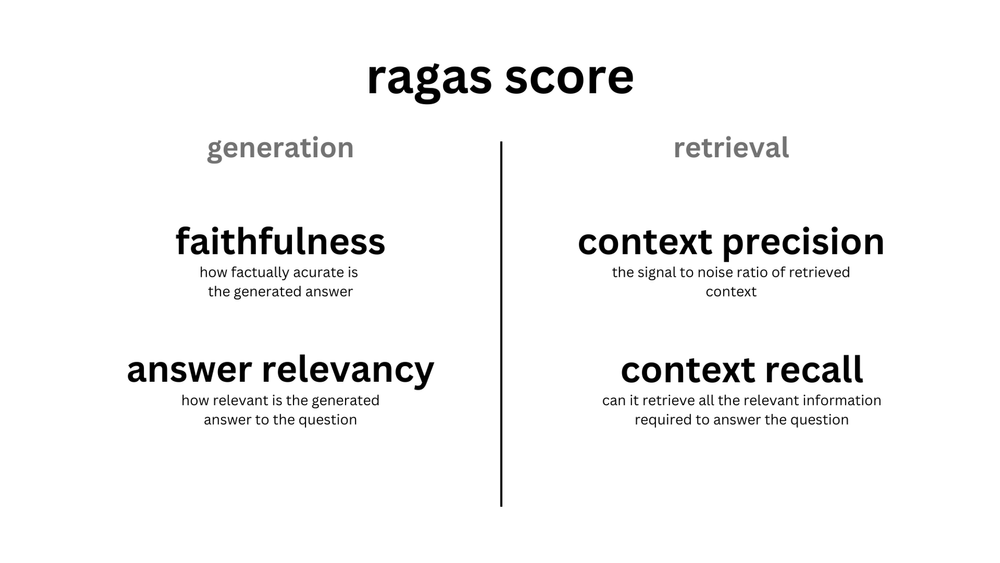

In [86]:
eval_dataset_512_3 = pd.read_csv('rag_response_512_3.csv')
eval_dataset_512_3.head(10)

,question,answer,contexts,ground_truth
0,What is vaccum optimizer ?,The Vacuum Optimizer in Qdrant is used to addr...,['document:--- title: Optimizer weight: 70 ali...,The Vacuum Optimizer is a feature in the Qdran...
1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter in the context of q...,['document:vectorsConfig: new VectorParams { S...,In the context of vector quantization in Qdran...
2,What is difference between scalar and product ...,Scalar Quantization and Product Quantization a...,['document:s</td> <td>474 s</td> </tr> </tbody...,While both methods aim to reduce the memory fo...
3,What is ‘best_score’ strategy?,The 'best_score' strategy is a new recommendat...,"['document:step happens very fast, the perform...",The `best_score` strategy is based on the idea...
4,How does oversampling helps?,Oversampling helps to control the precision of...,"[""document:if we're using smaller models that ...",Defines how many extra vectors should be pre-s...
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The purpose of the `CreatePayloadIndexAsync` f...,['document:Some(Operation::SetPayload(SetPaylo...,CreatePayloadIndexAsync is a method in the Qdr...
6,What is the purpose of ef_construct in HNSW ?,The `ef_construct` parameter in HNSW (Hierarch...,"['document:), ) ``` ```typescript client.updat...",In HNSW algorithm the ef_construct parameter i...
7,How do you use ‘ordering’ parameter?,"To use the 'ordering' parameter, you can speci...",['document:can be freely reordered. - `medium`...,Write ordering can be specified for any write ...
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in Qdrant determ...,"[""document:as cloud, happening when users were...",The `on_disk_payload` setting in the storage c...
9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` in Qdrant repre...,['document:request dispatches all operations a...,The `write_consistency_factor` parameter in a ...


### **RAGAS Metrics supported through Haystack**
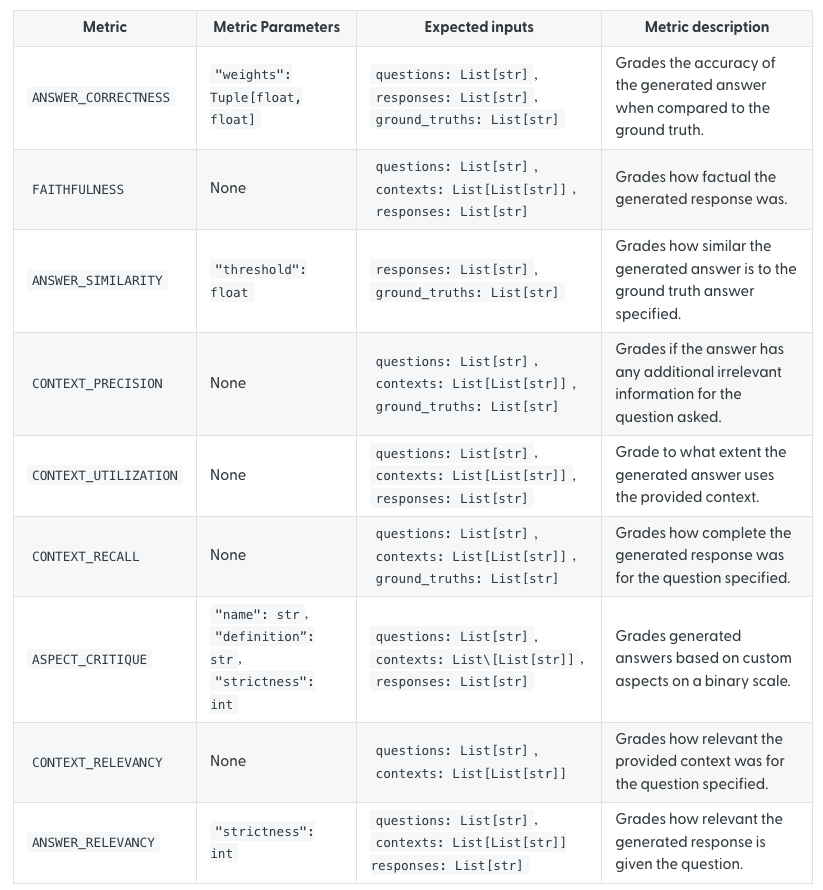

In [87]:
from haystack import Pipeline
from haystack_integrations.components.evaluators.ragas import RagasEvaluator, RagasMetric

def evaluate_eval_dataset(df):
  pipeline = Pipeline()
  ##To avoid format mismatch issue
  df['contexts'] = df['contexts'].apply(lambda x: eval(x) if isinstance(x, str) else [])

  QUESTIONS = df['question'].tolist()
  CONTEXTS = df['contexts'].tolist()
  ANSWERS = df['answer'].tolist()
  GROUND_TRUTHS = df['ground_truth'].tolist()

  ## Grades if the answer has any additional irrelevant information for the question asked.
  precision_evaluator = RagasEvaluator(metric=RagasMetric.CONTEXT_PRECISION)
    
  ## Grades how complete the generated response was for the question specified.
  recall_evaluator = RagasEvaluator(metric=RagasMetric.CONTEXT_RECALL)
    
  ## Grades how relevant the provided context was for the question specified.
  relevancy_evaluator = RagasEvaluator(metric=RagasMetric.CONTEXT_RELEVANCY)
    
  ## Grade to what extent the generated answer uses the provided context.
  context_utilization_evaluator = RagasEvaluator(metric=RagasMetric.CONTEXT_UTILIZATION)
    
  ## Grades how factual the generated response was.
  faithfullness_evaluator = RagasEvaluator(metric=RagasMetric.FAITHFULNESS)
    
  ## Grades how relevant the generated response is given the question.
  ## The strictness parameter plays a crucial role in maintaining a certain level of self-consistency in predictions, 
  ## with an ideal range typically falling between 2 to 4.
  answer_relevancy_evaluator = RagasEvaluator(metric=RagasMetric.ANSWER_RELEVANCY,
                                            metric_params={"strictness":3},)
    
  ## Grades the accuracy of the generated answer when compared to the ground truth.
  correctness_evaluator = RagasEvaluator(metric=RagasMetric.ANSWER_CORRECTNESS,
                                        metric_params={"weights": [0.8,0.9]},)
    
  ## Grades how similar the generated answer is to the ground truth answer specified.
  similarity_evaluator = RagasEvaluator(metric=RagasMetric.ANSWER_SIMILARITY,
                                        metric_params={"threshold": 0.9},)
    
  ## Grades generated answers based on custom aspects ('Toxicity' in this case) on a binary scale.
  ## Supported aspects - harmfulness, maliciousness, coherence, correctness, conciseness 
  aspect_critic_evaluator = RagasEvaluator(metric=RagasMetric.ASPECT_CRITIQUE,
                            metric_params={"name": "Toxicity", "definition": "Is this answer toxic for user?", "strictness": 3},)

  pipeline.add_component("precision_evaluator", precision_evaluator)
  pipeline.add_component("recall_evaluator", recall_evaluator)
  pipeline.add_component("relevancy_evaluator", relevancy_evaluator)
  pipeline.add_component("context_utilization_evaluator", context_utilization_evaluator)
  pipeline.add_component("faithfullness_evaluator", faithfullness_evaluator)
  pipeline.add_component("correctness_evaluator", correctness_evaluator)
  pipeline.add_component("answer_relevancy_evaluator", answer_relevancy_evaluator)
  pipeline.add_component("similarity_evaluator", similarity_evaluator)
  pipeline.add_component("aspect_critic_evaluator", aspect_critic_evaluator)

  results = pipeline.run(
      {
          "precision_evaluator": {"questions": QUESTIONS, "contexts": CONTEXTS, "ground_truths": GROUND_TRUTHS,},
          "recall_evaluator": {"questions": QUESTIONS, "contexts": CONTEXTS, "ground_truths": GROUND_TRUTHS,},
          "relevancy_evaluator": {"questions": QUESTIONS, "contexts": CONTEXTS,},
          "context_utilization_evaluator": {"questions": QUESTIONS, "contexts": CONTEXTS, "responses": ANSWERS},
          "faithfullness_evaluator": {"questions": QUESTIONS, "contexts": CONTEXTS, "responses": ANSWERS},
          "correctness_evaluator": {"questions": QUESTIONS, "ground_truths": GROUND_TRUTHS, "responses": ANSWERS},
          "answer_relevancy_evaluator": {"questions": QUESTIONS, "contexts": CONTEXTS, "responses": ANSWERS},
          "similarity_evaluator": {"ground_truths": GROUND_TRUTHS, "responses": ANSWERS},
          "aspect_critic_evaluator": {"questions": QUESTIONS, "contexts": CONTEXTS, "responses": ANSWERS},
      }
  )
  return results

In [88]:
## Exporting evaluation results to Dataframe for better visibility

import pandas as pd

def evaluation_results_to_dataframe(evaluation_outputs):
    # Initialize a list to hold all the rows of the DataFrame
    data_rows = []

    # Iterate over each evaluator in the evaluation outputs
    for evaluator_name, evaluator_data in evaluation_outputs.items():
        # Iterate over each result in this evaluator
        for result_index, result in enumerate(evaluator_data['results']):
            # Each result is a list with one dictionary
            for metric in result:
                # Append each metric to the data_rows list as a dictionary
                data_rows.append({
                    'Evaluator': evaluator_name,
                    'Index': result_index,
                    'Metric Name': metric['name'],
                    'Score': metric['score']
                })

    # Convert the list of dictionaries to a DataFrame
    return pd.DataFrame(data_rows)

In [89]:
## Merge eval dataset and metrics results dataset for summarised view

def merge_eval_and_metrics_dataset(eval_df,metrics_df):
  # Add an index column
  eval_df.reset_index(inplace=True)
  eval_df.rename(columns={'index': 'Index'}, inplace=True)
  #eval_df.drop('Index', axis=1,inplace=True)
  metrics_summary_df = metrics_df.pivot(index='Index', columns='Evaluator', values='Score')
  # Merge the DataFrames on the 'Index' column
  final_df = pd.merge(eval_df, metrics_summary_df, on='Index')
  #print(final_df)
  return final_df

In [90]:
## Run evaluation for Retreival Window Size 3 evaluation dataset
results_512_3 = evaluate_eval_dataset(eval_dataset_512_3)
evaluation_result_df_512_3 = evaluation_results_to_dataframe(results_512_3)
print(evaluation_result_df_512_3)
merged_df_512_3 = merge_eval_and_metrics_dataset(eval_dataset_512_3 , evaluation_result_df_512_3)

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without gro

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Task exception was never retrieved
future: <Task finished name='Task-301' coro=<AsyncClient.aclose() done, defined at /Users/atitaarora/qdrant/workspace/qdrant-rag-eval/workshop-rag-eval-qdrant-ragas-haystack/ragas-haystack/lib/python3.10/site-packages/httpx/_client.py:2011> exception=RuntimeError('Event loop is closed')>
Traceback (most recent call last):
  File "/Users/atitaarora/qdrant/workspace/qdrant-rag-eval/workshop-rag-eval-qdrant-ragas-haystack/ragas-haystack/lib/python3.10/site-packages/httpx/_client.py", line 2018, in aclose
    await self._transport.aclose()
  File "/Users/atitaarora/qdrant/workspace/qdrant-rag-eval/workshop-rag-eval-qdrant-ragas-haystack/ragas-haystack/lib/python3.10/site-packages/httpx/_transports/default.py", line 385, in aclose
    await self._pool.aclose()
  File "/Users/atitaarora/qdrant/workspace/qdrant-rag-eval/workshop-rag-eval-qdrant-ragas-haystack/ragas-haystack/lib/python3.10/site-packages/httpcore/_async/connection_pool.py", line 313, in aclose

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

                  Evaluator  Index        Metric Name Score
0       precision_evaluator      0  context_precision   1.0
1       precision_evaluator      1  context_precision   1.0
2       precision_evaluator      2  context_precision   1.0
3       precision_evaluator      3  context_precision   1.0
4       precision_evaluator      4  context_precision   1.0
..                      ...    ...                ...   ...
85  aspect_critic_evaluator      5           Toxicity     0
86  aspect_critic_evaluator      6           Toxicity     0
87  aspect_critic_evaluator      7           Toxicity     0
88  aspect_critic_evaluator      8           Toxicity     0
89  aspect_critic_evaluator      9           Toxicity     0

[90 rows x 4 columns]


In [91]:
merged_df_512_3

,Index,question,answer,contexts,ground_truth,answer_relevancy_evaluator,aspect_critic_evaluator,context_utilization_evaluator,correctness_evaluator,faithfullness_evaluator,precision_evaluator,recall_evaluator,relevancy_evaluator,similarity_evaluator
0,0,What is vaccum optimizer ?,The Vacuum Optimizer in Qdrant is used to addr...,[document:--- title: Optimizer weight: 70 alia...,The Vacuum Optimizer is a feature in the Qdran...,0.894643,0,1.0,0.826936,1.0,1.0,1.0,0.011765,True
1,1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter in the context of q...,[document:vectorsConfig: new VectorParams { Si...,In the context of vector quantization in Qdran...,0.878536,0,1.0,0.849971,0.666667,1.0,1.0,0.046512,True
2,2,What is difference between scalar and product ...,Scalar Quantization and Product Quantization a...,[document:s</td> <td>474 s</td> </tr> </tbody>...,While both methods aim to reduce the memory fo...,0.86862,0,1.0,0.70648,1.0,1.0,1.0,0.059701,True
3,3,What is ‘best_score’ strategy?,The 'best_score' strategy is a new recommendat...,"[document:step happens very fast, the performa...",The `best_score` strategy is based on the idea...,0.978604,0,1.0,0.7737,1.0,1.0,1.0,0.013699,True
4,4,How does oversampling helps?,Oversampling helps to control the precision of...,[document:if we're using smaller models that a...,Defines how many extra vectors should be pre-s...,0.903746,0,1.0,0.805451,0.5,1.0,0.666667,0.074074,False
5,5,What is the purpose of ‘CreatePayloadIndexAsync’?,The purpose of the `CreatePayloadIndexAsync` f...,[document:Some(Operation::SetPayload(SetPayloa...,CreatePayloadIndexAsync is a method in the Qdr...,0.979174,0,1.0,0.734945,0.666667,1.0,0.333333,0.009259,False
6,6,What is the purpose of ef_construct in HNSW ?,The `ef_construct` parameter in HNSW (Hierarch...,"[document:), ) ``` ```typescript client.update...",In HNSW algorithm the ef_construct parameter i...,0.9552,0,1.0,0.482904,0.833333,1.0,0.333333,0.011494,True
7,7,How do you use ‘ordering’ parameter?,"To use the 'ordering' parameter, you can speci...",[document:can be freely reordered. - `medium` ...,Write ordering can be specified for any write ...,0.842125,0,1.0,0.732848,0.388889,1.0,1.0,0.00885,False
8,8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in Qdrant determ...,"[document:as cloud, happening when users were ...",The `on_disk_payload` setting in the storage c...,0.88227,0,1.0,0.768304,0.0,1.0,1.0,0.022989,False
9,9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` in Qdrant repre...,[document:request dispatches all operations ac...,The `write_consistency_factor` parameter in a ...,0.904315,0,1.0,0.85995,0.8,1.0,1.0,0.016949,True


In [92]:
merged_df_512_3.to_csv("eval_results_512_3.csv")

### **15. Improvision step by modifying the number of chunks retrieved to 4 and recreate the evaluation dataset**

In [93]:
## Define the Config for generating the Eval dataset as below :

# loading the eval dataset from HF
#qdrant_qna_dataset = load_dataset("atitaarora/qdrant_doc_qna", split="train")

EVAL_SIZE = 10

RETRIEVAL_SIZE_4 = 4

#print(qdrant_qna_dataset.column_names)

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_eval_dataset_512_4 = create_eval_dataset(qdrant_qna_dataset,EVAL_SIZE,RETRIEVAL_SIZE_4)

Calculating embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.63it/s]


In [94]:
#rag_response_data

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_response_dataset_512_4 = Dataset.from_dict(rag_eval_dataset_512_4)
## Saving the evaluation dataset offline
rag_response_dataset_512_4.to_csv('rag_response_512_4.csv')

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

151264

In [95]:
eval_dataset_512_4 = pd.read_csv('rag_response_512_4.csv')
eval_dataset_512_4.head(10)

,question,answer,contexts,ground_truth
0,What is vaccum optimizer ?,The Vacuum Optimizer in Qdrant is used to addr...,['document:--- title: Optimizer weight: 70 ali...,The Vacuum Optimizer is a feature in the Qdran...
1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter in Qdrant determine...,['document:vectorsConfig: new VectorParams { S...,In the context of vector quantization in Qdran...
2,What is difference between scalar and product ...,Scalar quantization and product quantization a...,['document:s</td> <td>474 s</td> </tr> </tbody...,While both methods aim to reduce the memory fo...
3,What is ‘best_score’ strategy?,The 'best_score' strategy is a new recommendat...,"['document:step happens very fast, the perform...",The `best_score` strategy is based on the idea...
4,How does oversampling helps?,Oversampling helps to control the precision of...,"[""document:if we're using smaller models that ...",Defines how many extra vectors should be pre-s...
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The purpose of the 'CreatePayloadIndexAsync' f...,['document:Some(Operation::SetPayload(SetPaylo...,CreatePayloadIndexAsync is a method in the Qdr...
6,What is the purpose of ef_construct in HNSW ?,The `ef_construct` parameter in HNSW (Hierarch...,"['document:), ) ``` ```typescript client.updat...",In HNSW algorithm the ef_construct parameter i...
7,How do you use ‘ordering’ parameter?,"To use the 'ordering' parameter, you can speci...",['document:can be freely reordered. - `medium`...,Write ordering can be specified for any write ...
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in Qdrant determ...,"[""document:as cloud, happening when users were...",The `on_disk_payload` setting in the storage c...
9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` in Qdrant repre...,['document:request dispatches all operations a...,The `write_consistency_factor` parameter in a ...


In [96]:
## Run evaluation for Retreival Window Size 4 evaluation dataset
results_512_4 = evaluate_eval_dataset(eval_dataset_512_4)
evaluation_result_df_512_4 = evaluation_results_to_dataframe(results_512_4)
#print(evaluation_result_df_512_4)
merged_df_512_4 = merge_eval_and_metrics_dataset(eval_dataset_512_4 , evaluation_result_df_512_4)

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without gro

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Failed to parse output. Returning None.


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Failed to parse output. Returning None.


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Task exception was never retrieved
future: <Task finished name='Task-1295' coro=<AsyncClient.aclose() done, defined at /Users/atitaarora/qdrant/workspace/qdrant-rag-eval/workshop-rag-eval-qdrant-ragas-haystack/ragas-haystack/lib/python3.10/site-packages/httpx/_client.py:2011> exception=RuntimeError('Event loop is closed')>
Traceback (most recent call last):
  File "/Users/atitaarora/qdrant/workspace/qdrant-rag-eval/workshop-rag-eval-qdrant-ragas-haystack/ragas-haystack/lib/python3.10/site-packages/httpx/_client.py", line 2018, in aclose
    await self._transport.aclose()
  File "/Users/atitaarora/qdrant/workspace/qdrant-rag-eval/workshop-rag-eval-qdrant-ragas-haystack/ragas-haystack/lib/python3.10/site-packages/httpx/_transports/default.py", line 385, in aclose
    await self._pool.aclose()
  File "/Users/atitaarora/qdrant/workspace/qdrant-rag-eval/workshop-rag-eval-qdrant-ragas-haystack/ragas-haystack/lib/python3.10/site-packages/httpcore/_async/connection_pool.py", line 313, in aclos

In [97]:
merged_df_512_4

,Index,question,answer,contexts,ground_truth,answer_relevancy_evaluator,aspect_critic_evaluator,context_utilization_evaluator,correctness_evaluator,faithfullness_evaluator,precision_evaluator,recall_evaluator,relevancy_evaluator,similarity_evaluator
0,0,What is vaccum optimizer ?,The Vacuum Optimizer in Qdrant is used to addr...,[document:--- title: Optimizer weight: 70 alia...,The Vacuum Optimizer is a feature in the Qdran...,0.894643,0,1.0,0.795334,1.0,1.0,1.0,0.008475,True
1,1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter in Qdrant determine...,[document:vectorsConfig: new VectorParams { Si...,In the context of vector quantization in Qdran...,0.893226,0,1.0,0.782276,0.571429,1.0,1.0,0.037736,True
2,2,What is difference between scalar and product ...,Scalar quantization and product quantization a...,[document:s</td> <td>474 s</td> </tr> </tbody>...,While both methods aim to reduce the memory fo...,0.864467,0,1.0,0.596487,1.0,1.0,1.0,0.05102,True
3,3,What is ‘best_score’ strategy?,The 'best_score' strategy is a new recommendat...,"[document:step happens very fast, the performa...",The `best_score` strategy is based on the idea...,0.973762,0,1.0,0.494992,NaN,1.0,1.0,0.013158,True
4,4,How does oversampling helps?,Oversampling helps to control the precision of...,[document:if we're using smaller models that a...,Defines how many extra vectors should be pre-s...,0.846654,0,1.0,0.816604,0.857143,1.0,0.666667,0.051282,True
5,5,What is the purpose of ‘CreatePayloadIndexAsync’?,The purpose of the 'CreatePayloadIndexAsync' f...,[document:Some(Operation::SetPayload(SetPayloa...,CreatePayloadIndexAsync is a method in the Qdr...,0.983013,0,1.0,0.72109,0.25,1.0,1.0,0.006452,False
6,6,What is the purpose of ef_construct in HNSW ?,The `ef_construct` parameter in HNSW (Hierarch...,"[document:), ) ``` ```typescript client.update...",In HNSW algorithm the ef_construct parameter i...,0.945245,0,1.0,0.842379,0.75,1.0,0.666667,0.008197,True
7,7,How do you use ‘ordering’ parameter?,"To use the 'ordering' parameter, you can speci...",[document:can be freely reordered. - `medium` ...,Write ordering can be specified for any write ...,0.883042,0,1.0,0.752848,1.0,1.0,1.0,0.006289,False
8,8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in Qdrant determ...,"[document:as cloud, happening when users were ...",The `on_disk_payload` setting in the storage c...,0.854006,0,1.0,0.790199,0.0,1.0,1.0,0.01,True
9,9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` in Qdrant repre...,[document:request dispatches all operations ac...,The `write_consistency_factor` parameter in a ...,0.904315,0,1.0,0.892217,1.0,1.0,1.0,0.010309,True


In [98]:
merged_df_512_4.to_csv("eval_results_512_4.csv")

### **18. Improvision step by modifying the number of chunks retrieved to 5 and recreate the evaluation dataset**

In [99]:
## Define the Config for generating the Eval dataset as below :

# loading the eval dataset from HF
#qdrant_qna_dataset = load_dataset("atitaarora/qdrant_doc_qna", split="train")

EVAL_SIZE = 10

RETRIEVAL_SIZE_5 = 5

#print(qdrant_qna_dataset.column_names)

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_eval_dataset_512_5 = create_eval_dataset(qdrant_qna_dataset,EVAL_SIZE,RETRIEVAL_SIZE_5)


Calculating embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.97it/s]


In [100]:
#rag_response_data

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_response_dataset_512_5 = Dataset.from_dict(rag_eval_dataset_512_5)
## Saving the evaluation dataset offline
rag_response_dataset_512_5.to_csv('rag_response_512_5.csv')

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

182024

In [101]:
from ragas import evaluate
eval_dataset_512_5 = pd.read_csv('rag_response_512_5.csv')
eval_dataset_512_5.head(10)

,question,answer,contexts,ground_truth
0,What is vaccum optimizer ?,The Vacuum Optimizer in Qdrant is used to addr...,['document:--- title: Optimizer weight: 70 ali...,The Vacuum Optimizer is a feature in the Qdran...
1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter in Qdrant determine...,['document:vectorsConfig: new VectorParams { S...,In the context of vector quantization in Qdran...
2,What is difference between scalar and product ...,Scalar quantization and product quantization a...,['document:s</td> <td>474 s</td> </tr> </tbody...,While both methods aim to reduce the memory fo...
3,What is ‘best_score’ strategy?,The 'best_score' strategy is a new recommendat...,"['document:step happens very fast, the perform...",The `best_score` strategy is based on the idea...
4,How does oversampling helps?,Oversampling helps to control the precision of...,"[""document:if we're using smaller models that ...",Defines how many extra vectors should be pre-s...
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The purpose of the 'CreatePayloadIndexAsync' f...,['document:Some(Operation::SetPayload(SetPaylo...,CreatePayloadIndexAsync is a method in the Qdr...
6,What is the purpose of ef_construct in HNSW ?,The `ef_construct` parameter in HNSW (Hierarch...,"['document:), ) ``` ```typescript client.updat...",In HNSW algorithm the ef_construct parameter i...
7,How do you use ‘ordering’ parameter?,"To use the 'ordering' parameter, you can speci...",['document:can be freely reordered. - `medium`...,Write ordering can be specified for any write ...
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in Qdrant determ...,"[""document:as cloud, happening when users were...",The `on_disk_payload` setting in the storage c...
9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` in Qdrant repre...,['document:request dispatches all operations a...,The `write_consistency_factor` parameter in a ...


In [102]:
## Run evaluation for Retreival Window Size 5 evaluation dataset
results_512_5 = evaluate_eval_dataset(eval_dataset_512_5)
evaluation_result_df_512_5 = evaluation_results_to_dataframe(results_512_5)
print(evaluation_result_df_512_5)
merged_df_512_5 = merge_eval_and_metrics_dataset(eval_dataset_512_5 , evaluation_result_df_512_5)

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without gro

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

                  Evaluator  Index        Metric Name Score
0       precision_evaluator      0  context_precision   1.0
1       precision_evaluator      1  context_precision   1.0
2       precision_evaluator      2  context_precision   1.0
3       precision_evaluator      3  context_precision   1.0
4       precision_evaluator      4  context_precision   1.0
..                      ...    ...                ...   ...
85  aspect_critic_evaluator      5           Toxicity     0
86  aspect_critic_evaluator      6           Toxicity     0
87  aspect_critic_evaluator      7           Toxicity     0
88  aspect_critic_evaluator      8           Toxicity     0
89  aspect_critic_evaluator      9           Toxicity     0

[90 rows x 4 columns]


In [103]:
merged_df_512_5

,Index,question,answer,contexts,ground_truth,answer_relevancy_evaluator,aspect_critic_evaluator,context_utilization_evaluator,correctness_evaluator,faithfullness_evaluator,precision_evaluator,recall_evaluator,relevancy_evaluator,similarity_evaluator
0,0,What is vaccum optimizer ?,The Vacuum Optimizer in Qdrant is used to addr...,[document:--- title: Optimizer weight: 70 alia...,The Vacuum Optimizer is a feature in the Qdran...,0.893568,0,1.0,0.782076,1.0,1.0,1.0,0.00813,True
1,1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter in Qdrant determine...,[document:vectorsConfig: new VectorParams { Si...,In the context of vector quantization in Qdran...,0.895879,0,1.0,0.890046,0.6,1.0,1.0,0.034783,True
2,2,What is difference between scalar and product ...,Scalar quantization and product quantization a...,[document:s</td> <td>474 s</td> </tr> </tbody>...,While both methods aim to reduce the memory fo...,0.864467,0,1.0,0.641164,1.0,1.0,1.0,0.008696,True
3,3,What is ‘best_score’ strategy?,The 'best_score' strategy is a new recommendat...,"[document:step happens very fast, the performa...",The `best_score` strategy is based on the idea...,0.973762,0,1.0,0.853303,1.0,1.0,1.0,0.01,True
4,4,How does oversampling helps?,Oversampling helps to control the precision of...,[document:if we're using smaller models that a...,Defines how many extra vectors should be pre-s...,0.897075,0,1.0,0.803254,1.0,1.0,0.666667,0.010204,True
5,5,What is the purpose of ‘CreatePayloadIndexAsync’?,The purpose of the 'CreatePayloadIndexAsync' f...,[document:Some(Operation::SetPayload(SetPayloa...,CreatePayloadIndexAsync is a method in the Qdr...,0.983013,0,1.0,0.749361,1.0,1.0,0.333333,0.005525,False
6,6,What is the purpose of ef_construct in HNSW ?,The `ef_construct` parameter in HNSW (Hierarch...,"[document:), ) ``` ```typescript client.update...",In HNSW algorithm the ef_construct parameter i...,0.954442,0,1.0,0.580024,0.333333,1.0,0.666667,0.006579,True
7,7,How do you use ‘ordering’ parameter?,"To use the 'ordering' parameter, you can speci...",[document:can be freely reordered. - `medium` ...,Write ordering can be specified for any write ...,0.830361,0,1.0,0.782934,1.0,1.0,0.5,0.005952,False
8,8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in Qdrant determ...,"[document:as cloud, happening when users were ...",The `on_disk_payload` setting in the storage c...,0.88227,0,1.0,0.789923,0.0,1.0,1.0,0.009434,False
9,9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` in Qdrant repre...,[document:request dispatches all operations ac...,The `write_consistency_factor` parameter in a ...,0.904315,0,1.0,0.829938,1.0,1.0,1.0,0.021127,True


In [104]:
merged_df_512_5.to_csv("eval_results_512_5.csv")

### **19. Compare results with the previous evaluation iteration**

In [105]:
## Result comparison
import pandas as pd
import matplotlib.pyplot as plt

def compare_dataframes(df1, df2 , df3):
    # Extract the specified columns from both dataframes
    headers = ['answer_relevancy_evaluator', 'aspect_critic_evaluator', 'context_utilization_evaluator', 'correctness_evaluator', 'faithfullness_evaluator','precision_evaluator','recall_evaluator','relevancy_evaluator']

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(headers), figsize=(20, 4))

    # Plot bar plots for each header
    for i, header in enumerate(headers):
        print(df1[header])
        ax = axes[i]
        ax.bar(['RW_3','RW_4', 'RW_5'], [df1[header].mean(), df2[header].mean(), df3[header].mean()])
        ax.set_title(header)
        ax.set_ylabel('Mean Value')

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()


0    0.894643
1    0.878536
2     0.86862
3    0.978604
4    0.903746
5    0.979174
6      0.9552
7    0.842125
8     0.88227
9    0.904315
Name: answer_relevancy_evaluator, dtype: object
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: aspect_critic_evaluator, dtype: object
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: context_utilization_evaluator, dtype: object
0    0.826936
1    0.849971
2     0.70648
3      0.7737
4    0.805451
5    0.734945
6    0.482904
7    0.732848
8    0.768304
9     0.85995
Name: correctness_evaluator, dtype: object
0         1.0
1    0.666667
2         1.0
3         1.0
4         0.5
5    0.666667
6    0.833333
7    0.388889
8         0.0
9         0.8
Name: faithfullness_evaluator, dtype: object
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: precision_evaluator, dtype: object
0         1.0
1         1.0
2         1.0
3         1.0
4

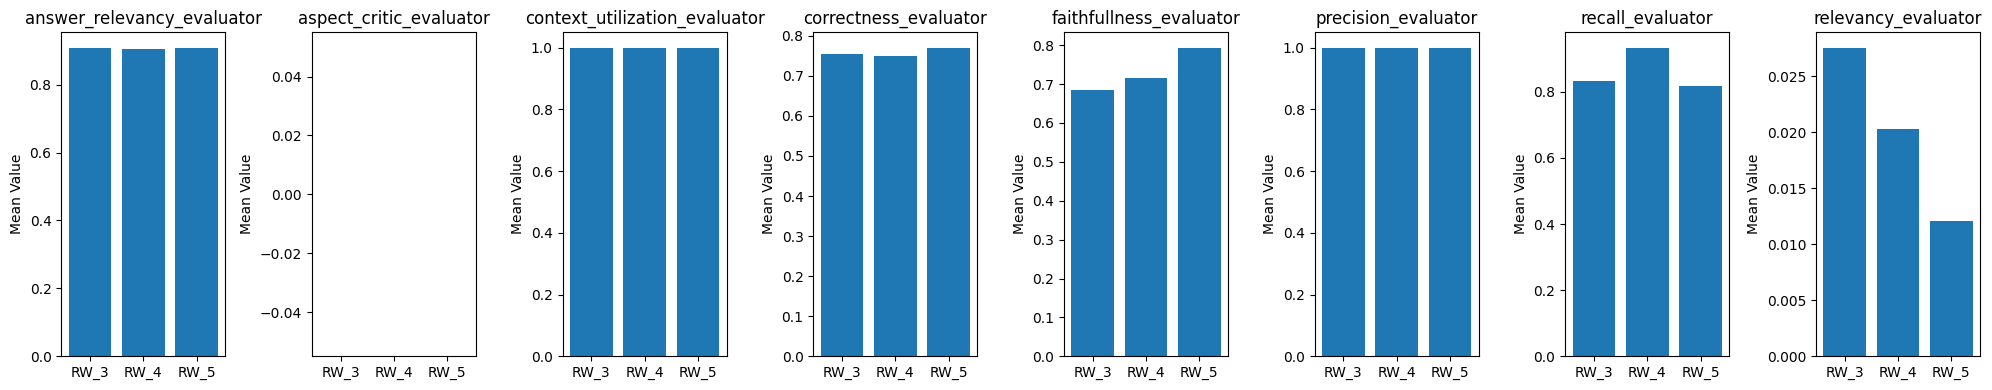

In [106]:
# Example result comparison:
compare_dataframes(merged_df_512_3, merged_df_512_4, merged_df_512_5)


In [34]:
#!pip install accelerate
!pip install "transformers[torch,sentencepiece]"

/Users/atitaarora/.zshenv:2: command too long: /Users/atitaarora/qdrant/workspace/qdrant-rag-eval/workshop-rag-eval-qdrant-ragas-haystack/ragas-haystack/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/Library/Apple/usr/bin:/Users/atitaarora/.cargo/bin:/Applications/iTerm.app/Contents/Resources/utilities=/Users/atitaarora/qdrant/workspace/qdrant-rag-eval/workshop-rag-eval-qdrant-ragas-haystack/ragas-haystack/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/c

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 4.6 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 4.2 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.7/401.7 kB 6.3 MB/s eta 0:00:006.1 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.1 MB/s eta 0:00:00m eta 0:00:010:00:01
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastembed 0.2.7 requires huggingface-hub<0.21,>=0.20, but you have h

In [32]:
from haystack import Document
from haystack import Pipeline
from haystack.components.rankers import TransformersSimilarityRanker
from haystack_integrations.components.retrievers.qdrant import QdrantEmbeddingRetriever
from haystack_integrations.components.embedders.fastembed import FastembedTextEmbedder

#mxbai = MixedbreadAI(api_key="emb_ec85e356576c062eb364139990780e90a55bd0a2520263ad")
reranker = TransformersSimilarityRanker()
#reranker = TransformersSimilarityRanker(
#    model = "mixedbread-ai/mxbai-rerank-large-v1",
#    token = Secret.from_token("emb_ec85e356576c062eb364139990780e90a55bd0a2520263ad")
#)
reranker.warm_up()

query_rerank_pipeline = Pipeline()
query_rerank_pipeline.add_component("query_embedder", FastembedTextEmbedder(model=EMBEDDING_MODEL))
query_rerank_pipeline.add_component("retriever", QdrantEmbeddingRetriever(document_store=document_store))
query_rerank_pipeline.add_component("reranker" , reranker)

query_rerank_pipeline.connect("query_embedder.embedding", "retriever.query_embedding")
query_rerank_pipeline.connect("retriever.documents", "reranker.documents")


ImportError: Failed to import 'transformers'. Run 'pip install transformers[torch,sentencepiece]'. Original error: No module named 'transformers'

In [ ]:
question ="what is binary quantization"
search_result = query_rerank_pipeline.run({"query_embedder": {"text": question}, 
                                           "retriever":{"top_k":4}}, 
                                           "reranker": {"query": query, "top_k": 3}})
for res in search_result["reranker"]["documents"]:
    print("Id: ", res.id)
    print("Document : " , res.content)
    print("Score : " , res.score)
    print("Source : " , res.meta['source'])
    print("----\n")